# Setting up a D1SUNED study

## Introduction to the problem

In this tutorial we will see how f4enix can help set up a d1suned study workflow from scratch. Let's start with a simple input consisting of a sphere of steel and a 0-14 MeV point source added at his center. Our objective will be to compute the contact SDDR at the external surface of the sphere (tally 104) after 24h and 11.6 days.

In [7]:
from f4enix.input.MCNPinput import D1S_Input

inp = D1S_Input.from_input('sphere.i')

# Check input contents
with open('sphere.i', 'r') as f:
    for line in f:
        if line.strip():
            print(line, end='')

MCNP XS LEAK SPHERE TEST INPUT VRT
1  0          -1    IMP:N=1   IMP:P=1
2  1 -7.93  +1 -2     IMP:N=1   IMP:P=1 
3  0         +2 -3  IMP:N=1   IMP:P=1
4  0          +3    IMP:N=0   IMP:P=0
1 S 0 0 0 5
2 S 0 0 0 50
3 S 0 0 0 55
4 S 0 0 0 60
M1
       6012.32c        1.167430E-4     $ C-12   AB(%) 98.93
       6013.32c        1.262660E-6     $ C-13   AB(%) 1.07
      25055.32c        1.564670E-3     $ Mn-55  AB(%) 100.0
      28058.32c        6.785300E-3     $ Ni-58  AB(%) 68.077
      28060.32c        2.613690E-3     $ Ni-60  AB(%) 26.223
      28061.32c        1.136150E-4     $ Ni-61  AB(%) 1.1399
      28062.32c        3.622550E-4     $ Ni-62  AB(%) 3.6345
      28064.32c        9.225560E-5     $ Ni-64  AB(%) 0.9256
      24050.32c        6.983620E-4     $ Cr-50  AB(%) 4.345
      24052.32c        1.346730E-2     $ Cr-52  AB(%) 83.789
      24053.32c        1.527070E-3     $ Cr-53  AB(%) 9.5009
      24054.32c        3.801180E-4     $ Cr-54  AB(%) 2.365
      42092.32c        1.84688

## Irradiation scenario and identification of decay pathways

First thing to do is to define the irradiation scenario(s) to be analyzed. This can be read from a fispact input or a d1stime legacy file if available or it can be directly created in F4Enix.

In [8]:
from f4enix.input.irradiation import IrradiationScenario, Pulse
from f4enix.constants import TIME_UNITS

# Dummy irradiation scenario: 2 cycles of 1 day ON, 1 day OFF, then 1 year OFF
# then again 2 cycles of 1 day ON, 1 day OFF
pulses = (
    [Pulse(1, 1e10, TIME_UNITS.DAY), Pulse(2, 0, TIME_UNITS.DAY)]*2 +
    [Pulse(1, 0, TIME_UNITS.YEAR)] +
    [Pulse(1, 1e10, TIME_UNITS.DAY), Pulse(2, 0, TIME_UNITS.DAY)]*2
)
irr_scenario = IrradiationScenario(pulses)


Next, we need to identify which nuclides should be tracked during the d1suned mode 1 calculation.
Usually, a previous activation code calculation must be run in order to identify what are the main decay pathways contributing to the SDDR in the problem at hands. In that case, simply a list of nuclides can be created and passed to f4enix to compute time correction factors.

For the sake of this tutorial we will assume that the flux at the external surface of the sphere is similar to the ones typically observed in a port interspace of ITER. We will also assume that the simple irradiation scenario defined here is similar to the SA2 one that was used to build the decay pathway library of F4Enix.

In [9]:
from f4enix.output.decay_pathways import PathwayLibrary
from f4enix.material_library import SS316LNIG

plib = PathwayLibrary()
df = plib.get_pathways(
    materials=[SS316LNIG],  # the only material present in our example
    cooling_times=['24h', '11.6d'],
    spectrum=['Eq. port interspace (175g)'],
    dose=95) # interested in getting 95% of the dose

df

max dose % at 24h  \
element isotope pathway                                                
Mn      54      Fe54 -(n,p)-> Mn54                         20.736861   
                Mn55 -(n,2n)-> Mn54                        20.736861   
Co      58      Ni58 -(n,p)-> Co58                         57.629401   
                Ni58 -(n,p)-> Co58m -(IT)->  Co58          57.629401   
        60      Co59 -(n,g)-> Co60                         12.626314   
                Co59 -(n,g)-> Co60m -(IT)->  Co60          12.626314   
                Ni60 -(n,p)-> Co60                         12.626314   
                Ni60 -(n,p)-> Co60m -(IT)->  Co60          12.626314   
Ni      57      Ni58 -(n,2n)-> Ni57                         1.111769   
Ta      182     Ta181 -(n,g)-> Ta182                        3.712906   

                                                   max dose % at 11.6d  
element isotope pathway                                                 
Mn      54      Fe54 -(n,p)-> Mn54                           22.368239  
                Mn55 -(n,2n)-> Mn54                          22.368239  
Co      58      Ni58 -(n,p)-> Co58                           57.413098  
                Ni58 -(n,p)-> Co58m -(IT)->  Co58            57.413098  
        60      Co59 -(n,g)-> Co60                           13.890249  
                Co59 -(n,g)-> Co60m -(IT)->  Co60            13.890249  
                Ni60 -(n,p)-> Co60                           13.890249  
                Ni60 -(n,p)-> Co60m -(IT)->  Co60            13.890249  
Ni      57      Ni58 -(n,2n)-> Ni57                                NaN  
Ta      182     Ta181 -(n,g)-> Ta182                          3.846353

Now that we know what are the interesting reactions we can firstly create the reaction and irradiation auxiliary files that are to be produced for a d1suned calculation.

## Irradiation and Reaction files production

### IRRAD file

First of all, let's extract the daughter radioactive isotopes for which the time correction factors need to be computed.

In [10]:
daugthers = df.reset_index()[['element', 'isotope']].drop_duplicates()
daugthers

,element,isotope
0,Mn,54
2,Co,58
4,Co,60
8,Ni,57
9,Ta,182


and then the time correction factors can be computed and the irradiation file created

In [11]:
from f4enix.input.d1suned import IrradiationFile
from f4enix.input.irradiation import Nuclide

nuclides = []
for element, isotope in daugthers.values:
    nuclides.append(Nuclide.from_formula(f"{element}{isotope}"))

irr_file = IrradiationFile.from_irradiation_schedules(
    nuclides,
    [irr_scenario],
    norm = 1.0e10, # normalization factor
)

# irr_file.write(r'./') # Write the irradiation file in the current directory

In [12]:
# Check out what we produced
with open('irrad', 'r') as f:
    for line in f:
        if line.strip():
            print(line, end='')

# *******************************
#     Irradiation Scenarios
# *******************************    
# norm: 10000000000.0
# Scenario: None
#   - Pulse(time=1.0 TIME_UNITS.DAY, intensity=10000000000.0)
#   - Pulse(time=2.0 TIME_UNITS.DAY, intensity=0)
#   - Pulse(time=1.0 TIME_UNITS.DAY, intensity=10000000000.0)
#   - Pulse(time=2.0 TIME_UNITS.DAY, intensity=0)
#   - Pulse(time=1.0 TIME_UNITS.YEAR, intensity=0)
#   - Pulse(time=1.0 TIME_UNITS.DAY, intensity=10000000000.0)
#   - Pulse(time=2.0 TIME_UNITS.DAY, intensity=0)
#   - Pulse(time=1.0 TIME_UNITS.DAY, intensity=10000000000.0)
#   - Pulse(time=2.0 TIME_UNITS.DAY, intensity=0)
nsc 1
C        Daught.   lambda(1/s)  time_fact_1   comments
         25054     2.570e-08    6.331e-03       Mn54
         27058     1.132e-07    1.932e-02       Co58
         27060     4.167e-09    1.348e-03       Co60
         28057     5.363e-06    1.834e-01       Ni57
         73182     6.994e-08    1.305e-02      Ta182


last thing to do is to assign the irrad file to the input

In [13]:
inp.irrad_file = irr_file

### REAC file

The fastest way to produce a reac file at this point is to use the ``get_reaction_file()`` method of the ``D1S_Input`` class. Given a specific D1S library, the method will scan the materials present in the input and add to the reaction list any available reaction that from one parent isotope included in the material can lead to one of the daughter isotopes included in the irrad file.

In [14]:
from f4enix.input.libmanager import LibManager

lm = LibManager()
inp.get_reaction_file(lm, '99c')

inp.reac_file


       Parent     MT    Daughter                                 Comment
    25055.99c     16       25054                        Mn55.99c -> Mn54
    26054.99c    103       25054                        Fe54.99c -> Mn54
    26056.99c    105       25054                        Fe56.99c -> Mn54
    27059.99c    102       27060                        Co59.99c -> Co60
    27059.99c     16       27058                        Co59.99c -> Co58
    28058.99c    103       27058                        Ni58.99c -> Co58
    28058.99c    112       25054                        Ni58.99c -> Mn54
    28058.99c     16       28057                        Ni58.99c -> Ni57
    28060.99c    103       27060                        Ni60.99c -> Co60
    28061.99c    104       27060                        Ni61.99c -> Co60
    28061.99c     28       27060                        Ni61.99c -> Co60
    29063.99c    107       27060                        Cu63.99c -> Co60
    73181.99c    102       73182                   

It can be noticed though how this list is longer than the one extracted with the help of the decay pathways filter:

In [15]:
df

max dose % at 24h  \
element isotope pathway                                                
Mn      54      Fe54 -(n,p)-> Mn54                         20.736861   
                Mn55 -(n,2n)-> Mn54                        20.736861   
Co      58      Ni58 -(n,p)-> Co58                         57.629401   
                Ni58 -(n,p)-> Co58m -(IT)->  Co58          57.629401   
        60      Co59 -(n,g)-> Co60                         12.626314   
                Co59 -(n,g)-> Co60m -(IT)->  Co60          12.626314   
                Ni60 -(n,p)-> Co60                         12.626314   
                Ni60 -(n,p)-> Co60m -(IT)->  Co60          12.626314   
Ni      57      Ni58 -(n,2n)-> Ni57                         1.111769   
Ta      182     Ta181 -(n,g)-> Ta182                        3.712906   

                                                   max dose % at 11.6d  
element isotope pathway                                                 
Mn      54      Fe54 -(n,p)-> Mn54                           22.368239  
                Mn55 -(n,2n)-> Mn54                          22.368239  
Co      58      Ni58 -(n,p)-> Co58                           57.413098  
                Ni58 -(n,p)-> Co58m -(IT)->  Co58            57.413098  
        60      Co59 -(n,g)-> Co60                           13.890249  
                Co59 -(n,g)-> Co60m -(IT)->  Co60            13.890249  
                Ni60 -(n,p)-> Co60                           13.890249  
                Ni60 -(n,p)-> Co60m -(IT)->  Co60            13.890249  
Ni      57      Ni58 -(n,2n)-> Ni57                                NaN  
Ta      182     Ta181 -(n,g)-> Ta182                          3.846353

irradiation list can further be refined accordingly, but for the sake of this example we will skip this part.

## D1SUNED input file finalization

Now that the irrad and reac file have been successfully generated it is time to provide some final touches to the input itself.
First of all, the correct D1S library should be assigned to the parent isotopes for which reactions have been defined.

In [16]:
inp.smart_translate(
    '99c', # activation library to use for parents
    '00c', # transport library to use for all other isotopes
    lm # LibManager of choice (default one can be used in most cases)
    )

print(inp.materials['M1'].to_text()[:1000])

M1
       6012.00c        1.167430E-4     $ C-12   WEIGHT(%) 0.029679 AB(%) 98.93
       6013.00c        1.262660E-6     $ C-13   WEIGHT(%) 0.029679 AB(%) 1.07
      25055.99c        1.564670E-3     $ Mn-55  WEIGHT(%) 1.8 AB(%) 100.0
      28058.99c        6.785300E-3     $ Ni-58  WEIGHT(%) 12.25 AB(%) 68.077
      28060.99c        2.613690E-3     $ Ni-60  WEIGHT(%) 12.25 AB(%) 26.223
      28061.99c        1.136150E-4     $ Ni-61  WEIGHT(%) 12.25 AB(%) 1.1399
      28062.00c        3.622550E-4     $ Ni-62  WEIGHT(%) 12.25 AB(%) 3.6345
      28064.00c        9.225560E-5     $ Ni-64  WEIGHT(%) 12.25 AB(%) 0.9256
      24050.00c        6.983620E-4     $ Cr-50  WEIGHT(%) 17.5 AB(%) 4.345
      24052.00c        1.346730E-2     $ Cr-52  WEIGHT(%) 17.5 AB(%) 83.789
      24053.00c        1.527070E-3     $ Cr-53  WEIGHT(%) 17.5 AB(%) 9.5009
      24054.00c        3.801180E-4     $ Cr-54  WEIGHT(%) 17.5 AB(%) 2.365
      42092.00c        1.846880E-4     $ Mo-92  WEIGHT(%) 2.5 AB(%) 14.84
     

And then the last final touches to automatically add the PIKMT card tracking all nuclides contained in the reaction file and creating a binning to isolate the different contributions of the daughters. Then the input can be written to file to start the simulations.

In [17]:
inp.add_PIKMT_card()
inp.add_daughter_contribution_from_irr('F104') # also subsets can be defined if needed

print(inp.other_data['PIKMT'].card())
print(inp.other_data['F104'].card())

# inp.write('production_sphere.i')


PIKMT
         25055    0
         26054    0
         26056    0
         27059    0
         28058    0
         28060    0
         28061    0
         29063    0
         73181    0

F104:p 3
FU104 0
         25054
         27058
         27060
         28057
         73182



## Post-processing of results

After your calculation was run, you can rescale your dose tallies (if binned by daughter contribution) for a new irradiation scenario.

In [ ]:
import matplotlib.pyplot as plt
from f4enix.output.mctal import Mctal, normalize_tally

# Read your mctal file
mctal = Mctal('mctal_daughter')

# Normalize dose tally
tallynum = 124
mctal.set_d1s_relative_contribution(tallynum)
dose_tally = mctal.tallydata[tallynum]
dose_tally## ##3#######


,Daughter,Value,Error,Normalized Value
0,0,0.000000e+00,0.0000,0.000000e+00
1,26059,1.736590e-05,0.0044,8.365197e-03
2,21046,3.319390e-07,0.0663,1.598958e-04
3,27058,3.043810e-04,0.0018,1.466211e-01
4,24051,1.588970e-05,0.0045,7.654108e-03
5,51124,2.588240e-11,0.1776,1.246762e-08
6,25054,1.599160e-04,0.0027,7.703194e-02
7,21048,7.115630e-07,0.0454,3.427617e-04
8,42099,1.215240e-05,0.0050,5.853841e-03
9,51122,1.058410e-11,0.2915,5.098387e-09


In [51]:
def plot_radioisotope_contribution(tally):
    plt.figure(figsize=(12, 8))
    plt.bar(tally["Daughter"].astype(str), tally["Normalized Value"], color="tab:blue")
    plt.xlabel("Daughter")
    plt.ylabel("Relative dose contribution [-]")
    plt.title(f"Daughter contribution to dose tally")
    plt.grid(axis="y")
    plt.xticks(rotation=45)  # Rotate x-tick labels if needed
    plt.tight_layout()
    plt.show()

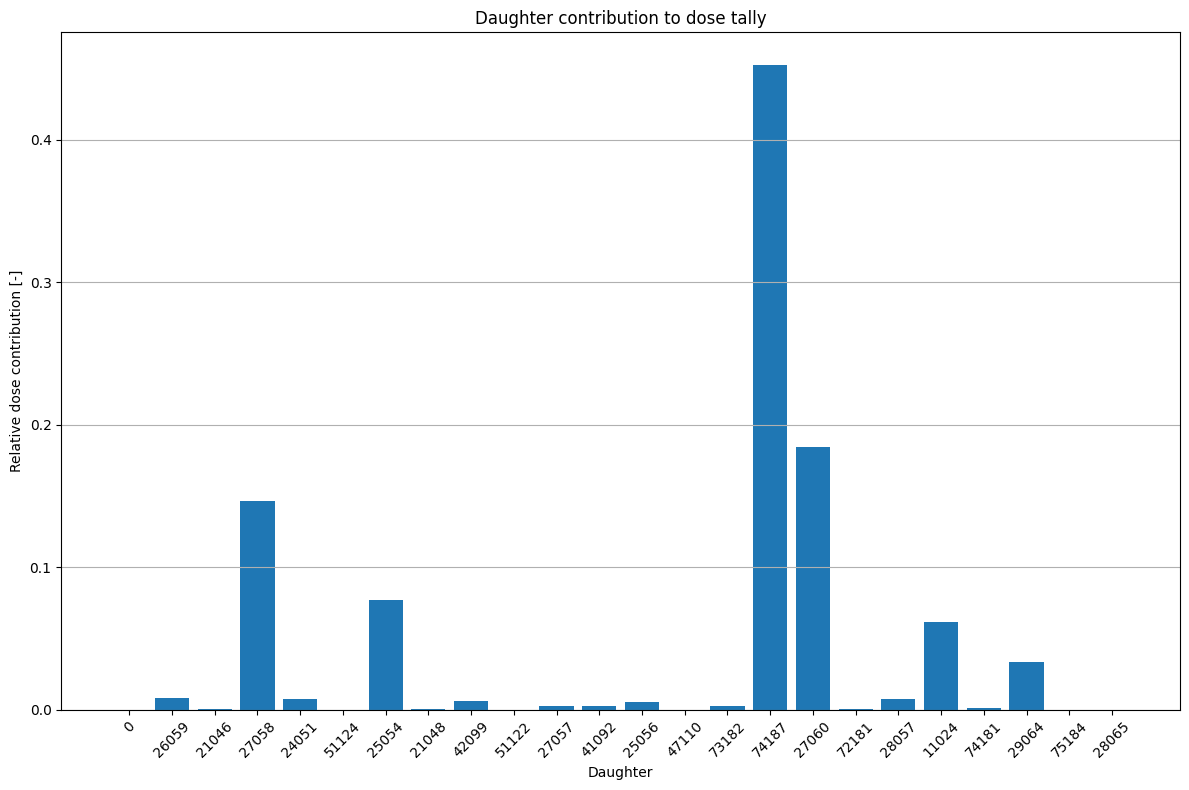

In [52]:
# Let's plot the daughters relative contributions
plot_radioisotope_contribution(dose_tally)

In [53]:
# define a new scenario (only 0 seconds cooling time)
new_pulses = (
    [Pulse(1, 1e10, TIME_UNITS.DAY), Pulse(2, 0, TIME_UNITS.DAY)]*2 +
    [Pulse(1, 0, TIME_UNITS.YEAR)] +
    [Pulse(1, 1e10, TIME_UNITS.DAY), Pulse(2, 0, TIME_UNITS.DAY)]*2
)
new_irr_scenario = IrradiationScenario(new_pulses)

In [54]:
# Generate scaling factors for the new scenario
scaling_factors = irr_file.get_scaling_factors_new_scenario(1, new_irr_scenario, norm=1.0e10)

# rescale the dose tally
new_dose_tally = dose_tally.copy()
scaling_col = scaling_factors.iloc[:, 0]
new_dose_tally["Value"] = new_dose_tally["Daughter"].map(scaling_col) * new_dose_tally["Value"]
normalize_tally(new_dose_tally)

,Daughter,Value,Error,Normalized Value
0,0,NaN,0.0000,NaN
1,26059,NaN,0.0044,NaN
2,21046,NaN,0.0663,NaN
3,27058,0.000304,0.0018,0.350637
4,24051,NaN,0.0045,NaN
5,51124,NaN,0.1776,NaN
6,25054,0.000160,0.0027,0.184273
7,21048,NaN,0.0454,NaN
8,42099,NaN,0.0050,NaN
9,51122,NaN,0.2915,NaN


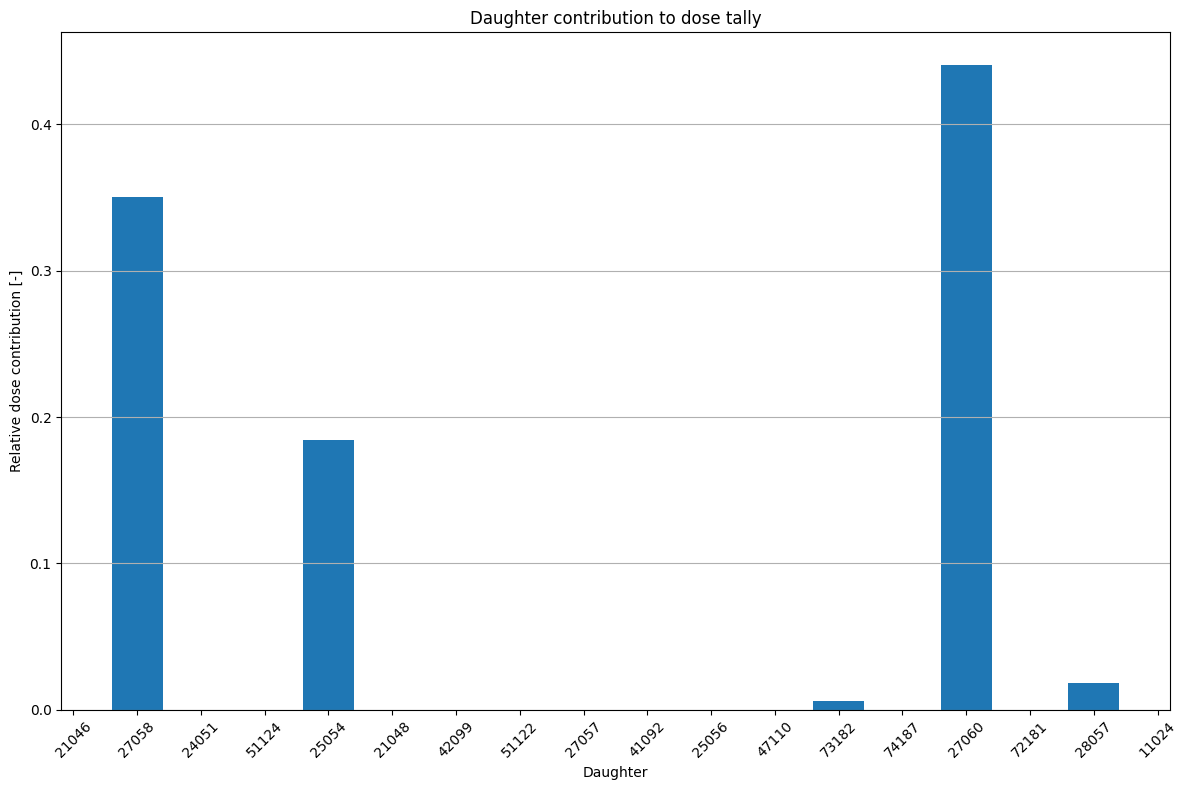

In [55]:
# Let's plot the relative daughter contribution after rescaling for the new scenario
plot_radioisotope_contribution(new_dose_tally)

We may also want to have the dose tally results for a different cooling time, it is possible again by rescaling the daughter contributions.

In [56]:
# Generate scaling factors for the new scenario
scaling_factors = irr_file.get_scaling_factors_cooling_time(1, (30, TIME_UNITS.DAY))

# rescale the dose tally
new_dose_tally = dose_tally.copy()
scaling_col = scaling_factors.iloc[:, 0]
new_dose_tally["Value"] = new_dose_tally["Daughter"].map(scaling_col) * new_dose_tally["Value"]
normalize_tally(new_dose_tally)

,Daughter,Value,Error,Normalized Value
0,0,NaN,0.0000,NaN
1,26059,NaN,0.0044,NaN
2,21046,NaN,0.0663,NaN
3,27058,2.269809e-04,0.0018,2.989156e-01
4,24051,NaN,0.0045,NaN
5,51124,NaN,0.1776,NaN
6,25054,1.496104e-04,0.0027,1.970248e-01
7,21048,NaN,0.0454,NaN
8,42099,NaN,0.0050,NaN
9,51122,NaN,0.2915,NaN


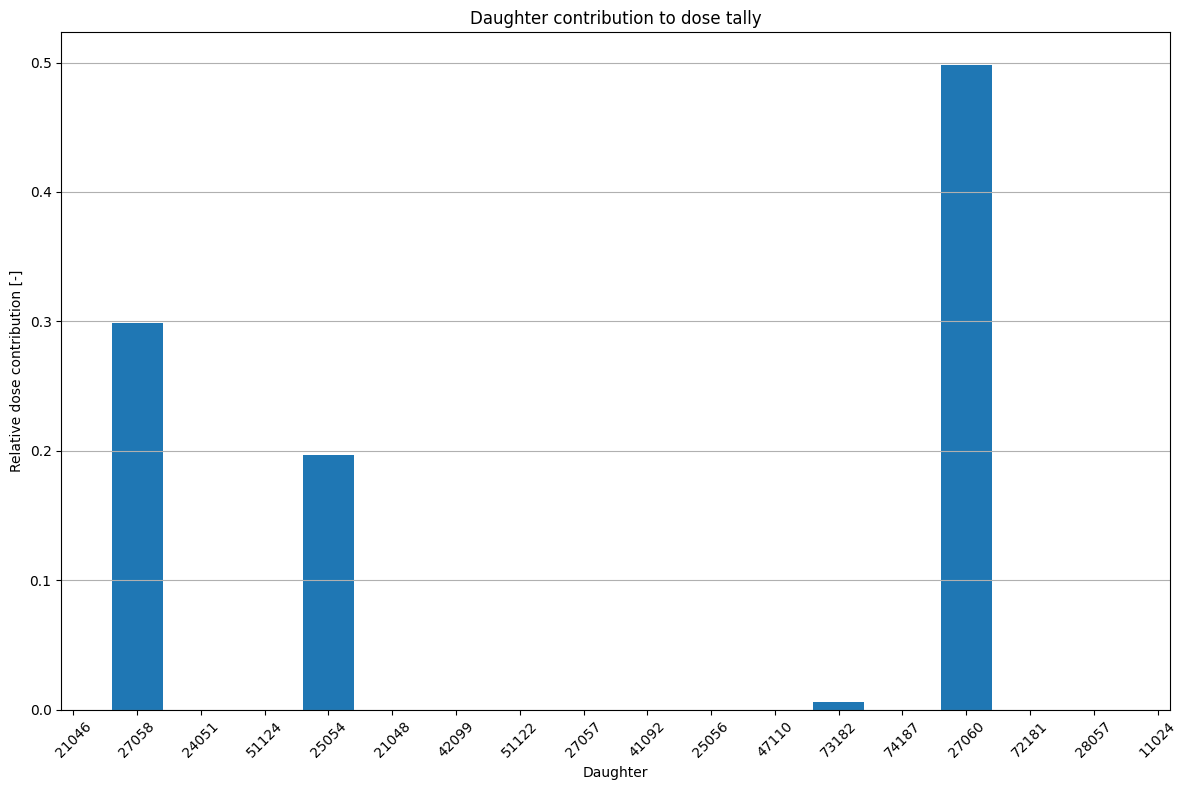

In [57]:
# Let's plot the relative daughter contribution after rescaling for the new cooling time
plot_radioisotope_contribution(new_dose_tally)